In [63]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from data_loader import load
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [64]:
#X_train, y_train: use for training and validating
#stratify_criterion: used to make sure each fold in cross validation has the same annotator agreement distribution
#X_test, y_test: only use for estimating final performance, prof really emphasized this (weird kink but ok)
X_train, y_train, stratify_criterion, X_test, y_test = load()

X_train_no_empty = X_train[y_train != 0]
stratify_criterion_no_empty = stratify_criterion[y_train != 0]
y_train_no_empty = y_train[y_train != 0]
y_train_no_empty -= 1

X_test_no_empty = X_test[y_test != 0]
y_test_no_empty = y_test[y_test != 0]
y_test_no_empty -= 1

print(X_train.shape, y_train.shape, stratify_criterion.shape, X_test.shape, y_test.shape)
print(X_train_no_empty.shape, y_train_no_empty.shape, stratify_criterion_no_empty.shape, X_test_no_empty.shape, y_test_no_empty.shape)

(96000, 548) (96000,) (96000,) (24000, 548) (24000,)
(27715, 548) (27715,) (27715,) (6927, 548) (6927,)


In [69]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, draw_confusion, y_names):
    num_batches = len(dataloader)
    test_loss = 0

    confusion = None
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_vec = pred.argmax(1).cpu()
            y_vec = y.argmax(1).cpu()
            accuracy += accuracy_score(y_vec, pred_vec)
            confusion = confusion_matrix(y_vec, pred_vec) if confusion is None else confusion + confusion_matrix(pred_vec, y_vec) 

    test_loss /= num_batches
    accuracy /= num_batches
    print(f"Accuracy: {accuracy:>8f} Avg loss: {test_loss:>8f} \n")
    if draw_confusion:
        sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=y_names, yticklabels=y_names, fmt="d")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show(block=False)

def eval(model, X, y, y_names, criterion, epochs):
    skf = StratifiedKFold(3)
    scaler = StandardScaler()
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    for i, (train_index, validate_index) in enumerate(skf.split(X, criterion)):
        
        print(f"===============================\nFold {i+1}\n===============================")

        X_fold = X[train_index]
        scaler.fit(X_fold)
        X_fold = scaler.transform(X_fold)
        X_fold = torch.Tensor(X_fold).to(device)

        y_fold = y[train_index]
        y_fold = np.eye(np.max(y)+1)[y_fold]
        y_fold = torch.Tensor(y_fold).to(device)

        X_validate = X[validate_index]
        X_validate = scaler.transform(X_validate)
        X_validate = torch.Tensor(X_validate).to(device)

        y_validate = y[validate_index]
        y_validate = np.eye(np.max(y)+1)[y_validate]
        y_validate = torch.Tensor(y_validate).to(device)

        model = model.to(device)

        train_dataloader = DataLoader(TensorDataset(X_fold, y_fold), batch_size=64)
        test_dataset = TensorDataset(X_validate, y_validate)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss().to(device)
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer)
            test(test_dataloader, model, loss_fn, t == epochs-1, y_names)


Fold 1
Epoch 1
-------------------------------
loss: 1.951818  [   64/64000]
loss: 0.185027  [19264/64000]
loss: 1.054288  [38464/64000]
loss: 0.370615  [57664/64000]
Accuracy: 0.674063 Avg loss: 1.215531 

Epoch 2
-------------------------------
loss: 4.464753  [   64/64000]
loss: 0.123677  [19264/64000]
loss: 0.025355  [38464/64000]
loss: 0.157932  [57664/64000]
Accuracy: 0.720500 Avg loss: 0.967627 

Epoch 3
-------------------------------
loss: 4.081114  [   64/64000]
loss: 0.123099  [19264/64000]
loss: 0.008086  [38464/64000]
loss: 0.088297  [57664/64000]
Accuracy: 0.755313 Avg loss: 0.866639 

Epoch 4
-------------------------------
loss: 3.750568  [   64/64000]
loss: 0.128117  [19264/64000]
loss: 0.005772  [38464/64000]
loss: 0.074549  [57664/64000]
Accuracy: 0.772687 Avg loss: 0.825856 

Epoch 5
-------------------------------
loss: 3.547927  [   64/64000]
loss: 0.131081  [19264/64000]
loss: 0.005205  [38464/64000]
loss: 0.073655  [57664/64000]
Accuracy: 0.779438 Avg loss: 0.80

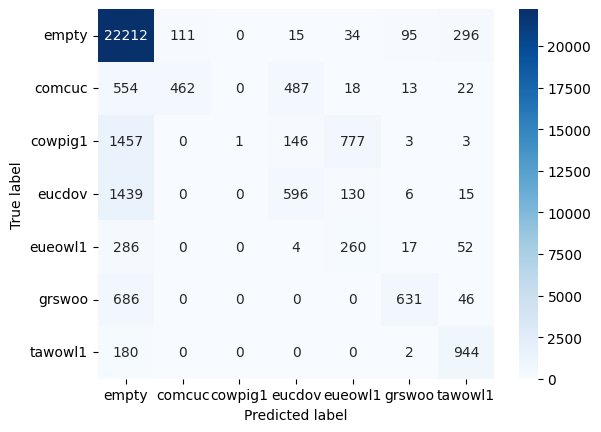

Fold 2
Epoch 1
-------------------------------
loss: 3.646369  [   64/64000]
loss: 0.323102  [19264/64000]
loss: 0.072527  [38464/64000]
loss: 0.101758  [57664/64000]
Accuracy: 0.833313 Avg loss: 0.501556 

Epoch 2
-------------------------------
loss: 2.219182  [   64/64000]
loss: 0.358180  [19264/64000]
loss: 0.077004  [38464/64000]
loss: 0.097612  [57664/64000]
Accuracy: 0.831438 Avg loss: 0.503308 

Epoch 3
-------------------------------
loss: 1.913635  [   64/64000]
loss: 0.357821  [19264/64000]
loss: 0.069882  [38464/64000]
loss: 0.095693  [57664/64000]
Accuracy: 0.830000 Avg loss: 0.505682 

Epoch 4
-------------------------------
loss: 1.751439  [   64/64000]
loss: 0.354367  [19264/64000]
loss: 0.064472  [38464/64000]
loss: 0.095774  [57664/64000]
Accuracy: 0.830375 Avg loss: 0.507040 

Epoch 5
-------------------------------
loss: 1.627360  [   64/64000]
loss: 0.351901  [19264/64000]
loss: 0.060082  [38464/64000]
loss: 0.094858  [57664/64000]
Accuracy: 0.831000 Avg loss: 0.50

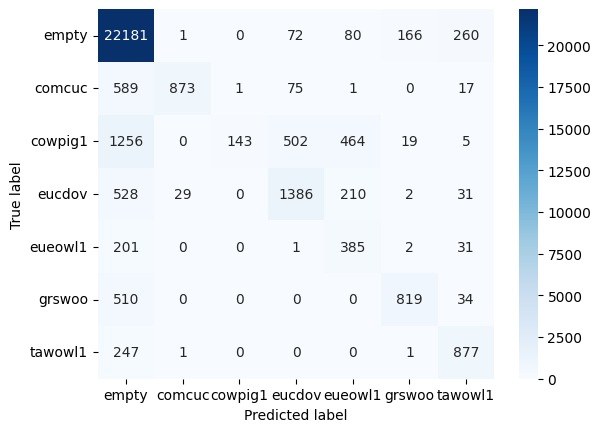

Fold 3
Epoch 1
-------------------------------
loss: 1.190366  [   64/64000]
loss: 0.327457  [19264/64000]
loss: 0.216897  [38464/64000]
loss: 0.135302  [57664/64000]
Accuracy: 0.644906 Avg loss: 1.033411 

Epoch 2
-------------------------------
loss: 1.103450  [   64/64000]
loss: 0.335164  [19264/64000]
loss: 0.221749  [38464/64000]
loss: 0.135971  [57664/64000]
Accuracy: 0.660500 Avg loss: 1.010979 

Epoch 3
-------------------------------
loss: 1.037826  [   64/64000]
loss: 0.329493  [19264/64000]
loss: 0.218350  [38464/64000]
loss: 0.136392  [57664/64000]
Accuracy: 0.668281 Avg loss: 1.002416 

Epoch 4
-------------------------------
loss: 0.949290  [   64/64000]
loss: 0.322225  [19264/64000]
loss: 0.214317  [38464/64000]
loss: 0.135655  [57664/64000]
Accuracy: 0.673406 Avg loss: 1.003519 

Epoch 5
-------------------------------
loss: 0.884699  [   64/64000]
loss: 0.311724  [19264/64000]
loss: 0.209244  [38464/64000]
loss: 0.134258  [57664/64000]
Accuracy: 0.676781 Avg loss: 1.01

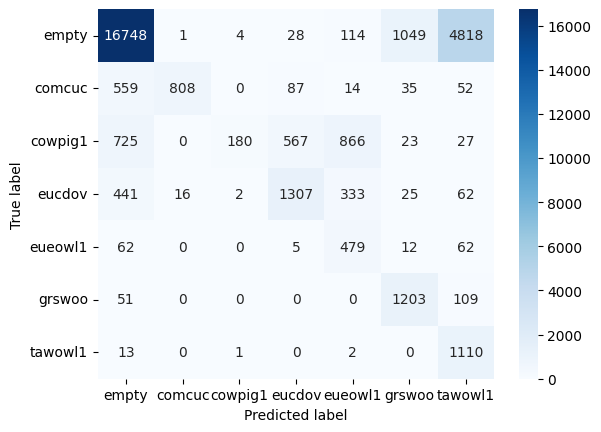

In [70]:
#Testing on entire dataset leads to massive bias towards empty class
model = nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

eval(model, X_train, y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 8)

Fold 1
Epoch 1
-------------------------------
loss: 1.812763  [   64/18476]
Accuracy: 0.141357 Avg loss: 1.941104 

Epoch 2
-------------------------------
loss: 2.775785  [   64/18476]
Accuracy: 0.312696 Avg loss: 1.708384 

Epoch 3
-------------------------------
loss: 2.626379  [   64/18476]
Accuracy: 0.437169 Avg loss: 1.549147 

Epoch 4
-------------------------------
loss: 2.638316  [   64/18476]
Accuracy: 0.484143 Avg loss: 1.457661 

Epoch 5
-------------------------------
loss: 2.617682  [   64/18476]
Accuracy: 0.515207 Avg loss: 1.384681 

Epoch 6
-------------------------------
loss: 2.557781  [   64/18476]
Accuracy: 0.535231 Avg loss: 1.324865 

Epoch 7
-------------------------------
loss: 2.459427  [   64/18476]
Accuracy: 0.553523 Avg loss: 1.278097 

Epoch 8
-------------------------------
loss: 2.330781  [   64/18476]
Accuracy: 0.570300 Avg loss: 1.240727 

Epoch 9
-------------------------------
loss: 2.160951  [   64/18476]
Accuracy: 0.585561 Avg loss: 1.207807 

Epo

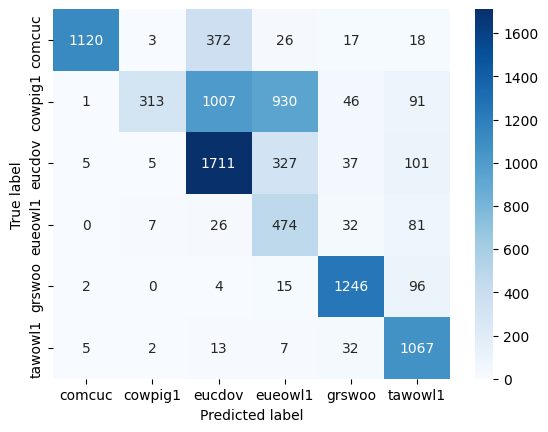

Fold 2
Epoch 1
-------------------------------
loss: 2.118809  [   64/18477]
Accuracy: 0.704265 Avg loss: 0.759513 

Epoch 2
-------------------------------
loss: 1.430501  [   64/18477]
Accuracy: 0.704265 Avg loss: 0.763613 

Epoch 3
-------------------------------
loss: 1.112121  [   64/18477]
Accuracy: 0.708270 Avg loss: 0.760239 

Epoch 4
-------------------------------
loss: 0.950837  [   64/18477]
Accuracy: 0.709894 Avg loss: 0.762532 

Epoch 5
-------------------------------
loss: 0.827351  [   64/18477]
Accuracy: 0.713033 Avg loss: 0.767610 

Epoch 6
-------------------------------
loss: 0.738198  [   64/18477]
Accuracy: 0.715848 Avg loss: 0.772312 

Epoch 7
-------------------------------
loss: 0.668507  [   64/18477]
Accuracy: 0.718121 Avg loss: 0.776459 

Epoch 8
-------------------------------
loss: 0.611989  [   64/18477]
Accuracy: 0.720178 Avg loss: 0.779555 

Epoch 9
-------------------------------
loss: 0.564096  [   64/18477]
Accuracy: 0.723641 Avg loss: 0.781460 

Epo

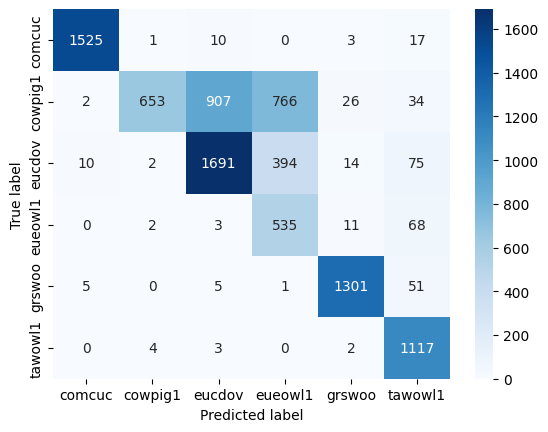

Fold 3
Epoch 1
-------------------------------
loss: 0.428958  [   64/18477]
Accuracy: 0.693332 Avg loss: 1.127200 

Epoch 2
-------------------------------
loss: 0.347098  [   64/18477]
Accuracy: 0.697012 Avg loss: 1.114901 

Epoch 3
-------------------------------
loss: 0.312430  [   64/18477]
Accuracy: 0.700476 Avg loss: 1.113867 

Epoch 4
-------------------------------
loss: 0.288960  [   64/18477]
Accuracy: 0.702750 Avg loss: 1.115774 

Epoch 5
-------------------------------
loss: 0.268679  [   64/18477]
Accuracy: 0.705889 Avg loss: 1.117736 

Epoch 6
-------------------------------
loss: 0.251888  [   64/18477]
Accuracy: 0.707729 Avg loss: 1.118885 

Epoch 7
-------------------------------
loss: 0.237544  [   64/18477]
Accuracy: 0.709244 Avg loss: 1.123111 

Epoch 8
-------------------------------
loss: 0.223876  [   64/18477]
Accuracy: 0.710760 Avg loss: 1.124997 

Epoch 9
-------------------------------
loss: 0.211463  [   64/18477]
Accuracy: 0.713033 Avg loss: 1.127100 

Epo

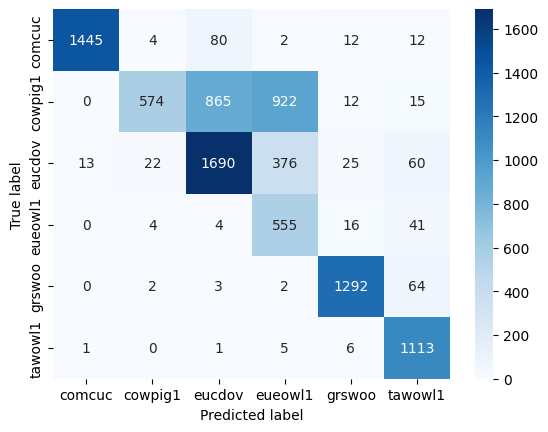

In [71]:
#Maybe NN is only useful for difference between birds
model = nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 6)
    )
eval(model, X_train_no_empty, y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 15)